参数设置：
空间点数 nx=201, 空间长度 L=2.0, 空间步长 dx=0.0100
时间步数 nt=250, 时间步长 dt=0.001
粘性系数 nu=0.0

使用TVD格式 (Van Leer限制器)
开始求解伯格斯方程...
计算完成。


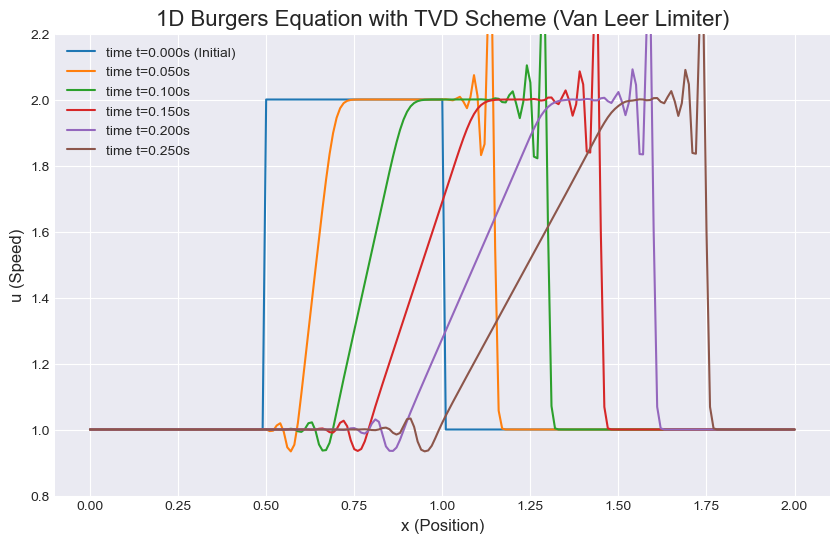

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. 设置模拟参数 ---
# 空间域参数
nx = 201              # 空间点数 (增加点数以获得更清晰的图像)
L = 2.0               # 空间长度 (米)
dx = L / (nx - 1)     # 空间步长 (米)

# 时间域参数
nt = 250              # 总时间步数
dt = 0.001            # 每个时间步的大小 (秒)

# 物理参数
# 注意：我们将nu设为0，以专注于观察TVD格式对数值误差的抑制效果
nu = 0.0

print(f"参数设置：\n空间点数 nx={nx}, 空间长度 L={L}, 空间步长 dx={dx:.4f}")
print(f"时间步数 nt={nt}, 时间步长 dt={dt}\n粘性系数 nu={nu}")

# --- TVD格式新增部分：定义通量限制器 ---
def van_leer_limiter(r):
    """
    Van Leer通量限制器函数
    输入r: 连续梯度之比
    输出psi: 限制器函数值
    """
    # abs(r)是为了处理r为负数的情况
    return (r + abs(r)) / (1 + abs(r))

print("\n使用TVD格式 (Van Leer限制器)")

# --- 2. 定义初始条件 ---
u = np.ones(nx)
start_idx = int(0.5 / dx)
end_idx = int(1.0 / dx + 1)
u[start_idx:end_idx] = 2.0

solutions = [u.copy()]

# --- 3. 实现时间循环 (TVD版本) ---
print("开始求解伯格斯方程...")
for n in range(nt):
    un = u.copy()
    
    # 创建一个数组来存储每个单元右边界的通量F
    flux = np.zeros(nx)
    
    # 遍历所有内部单元的右边界 (从 i=0 到 i=nx-2)
    # 我们需要计算 F_{i+1/2}
    for i in range(nx - 1):
        
        # --- a. 计算梯度比 r ---
        # 梯度比 r_i = (u_i - u_{i-1}) / (u_{i+1} - u_i)
        # 为了避免除以零，在分母上加一个极小值 epsilon
        epsilon = 1e-6
        
        # 检查边界条件，避免索引越界
        if i > 0:
            numerator = un[i] - un[i-1]
            denominator = un[i+1] - un[i]
            r = numerator / (denominator + epsilon)
        else:
            # 在最左边的边界，没有上游梯度，r可以设为1
            r = 1.0

        # --- b. 计算限制器 psi ---
        psi = van_leer_limiter(r)
        
        # --- c. 计算总通量 F ---
        # TVD通量公式: F_{i+1/2} = F_low + 0.5 * psi * (1 - c) * (F_high - F_low)
        # 这里我们使用一种更常见的表达形式
        # F_{i+1/2} = 0.5 * a * (u_i + u_{i+1}) - 0.5 * a^2 * dt/dx * (1-psi) * (u_{i+1}-u_i)
        # 为了简化，我们使用基于通量差的TVD格式
        
        # 速度a取两个单元的平均值
        a = 0.5 * (un[i] + un[i+1])
        
        # 低阶通量(一阶迎风)  是一阶迎风格式的通量表示
        flux_low = a * un[i]
        
        # 高阶通量(Lax-Wendroff)  公式代表的是Lax-Wendroff 格式的通量，这是一种二阶精度的格式
        flux_high = a * (0.5 * (un[i] + un[i+1]) - 0.5 * a * dt/dx * (un[i+1] - un[i]))
        
        # 限制后的高阶修正项
        # 注意：这里的phi是限制器作用于通量差
        phi = 0.5 * psi * (1 - abs(a * dt/dx))
        
        # 计算最终通量
        # F_{i+1/2} = F_upwind + phi * (u_{i+1} - u_i)
        if a > 0:
            flux[i] = a * un[i] + phi * (un[i+1] - un[i])
        else:
            flux[i] = a * un[i+1] - phi * (un[i+1] - un[i])


    # --- d. 更新解 ---
    # 遍历所有内部空间点来更新u的值
    # u_i^{n+1} = u_i^n - (dt/dx) * (F_{i+1/2} - F_{i-1/2})
    for i in range(1, nx - 1):
        u[i] = un[i] - (dt / dx) * (flux[i] - flux[i-1])

    # 每隔 50 步保存一次结果
    if (n + 1) % 50 == 0:
        solutions.append(u.copy())
        
print("计算完成。")
        
# --- 4. 可视化结果 ---
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(10, 6))

# 绘制不同时间步的解
for i, sol in enumerate(solutions):
    time = (i * 50 * dt) if i > 0 else 0
    label_text = f'time t={time:.3f}s'
    if i == 0:
        label_text += " (Initial)"
    plt.plot(np.linspace(0, L, nx), sol, label=label_text)

plt.title('1D Burgers Equation with TVD Scheme (Van Leer Limiter)', fontsize=16)
plt.xlabel('x (Position)', fontsize=12)
plt.ylabel('u (Speed)', fontsize=12)
plt.legend()
plt.ylim(0.8, 2.2)
plt.grid(True)
plt.show()


In [56]:
results

{'t': [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0],
 'u': [array([ 0.00000000e+00,  3.14107591e-02,  6.27905195e-02,  9.41083133e-02,
          1.25333234e-01,  1.56434465e-01,  1.87381315e-01,  2.18143241e-01,
          2.48689887e-01,  2.78991106e-01,  3.09016994e-01,  3.38737920e-01,
          3.68124553e-01,  3.97147891e-01,  4.25779292e-01,  4.53990500e-01,
          4.81753674e-01,  5.09041416e-01,  5.35826795e-01,  5.62083378e-01,
          5.87785252e-01,  6.12907054e-01,  6.37423990e-01,  6.61311865e-01,
          6.84547106e-01,  7.07106781e-01,  7.28968627e-01,  7.50111070e-01,
          7.70513243e-01,  7.90155012e-01,  8.09016994e-01,  8.27080574e-01,
          8.44327926e-01,  8.60742027e-01,  8.76306680e-01,  8.91006524e-01,
          9.04827052e-01,  9.17754626e-01,  9.29776486e-01,  9.40880769e-01,
          9.51056516e-01,  9.60293686e-01,  9.68583161e-01,  9.75916762e-01,
          9.82287251e-01,  9.87688341e-01,  9.92114701e-01,  9.95561965e-01,
          9.980267